In [1]:
'''
https://portal.icuregswe.org/utdata/sv/report/prod.belaggning

REMEMBER to add new,additional years to list years below 
'''

'\nhttps://portal.icuregswe.org/utdata/sv/report/prod.belaggning\n\nREMEMBER to add new,additional years to list years below \n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

In [3]:
all_data = pd.DataFrame()

In [4]:
def read_occupacy(fname):
    excel_file = pd.ExcelFile(fname)
    
    sheet = excel_file.sheet_names
    
    df = excel_file.parse(sheet_names=sheet,skiprows=1)
    df.columns = ['Datum','Platser'] ### sometimes get english columns ###
    df['date'] = pd.to_datetime(df['Datum'])
    df.drop('Datum',inplace=True,axis=1)
    df.set_index('date',inplace=True)
    df.rename(columns={'Platser' : 'occupacy'},inplace=True)
    df = df.resample('D').mean()
    
    
    return (df)

In [5]:
years = ['2016','2017','2018','2019','2020','2021','2022']

In [6]:
for y in years:
    df = read_occupacy('iva_occupacy_' + y + '.xlsx')
    all_data = pd.concat([all_data,df])


In [7]:
all_data

,occupacy
date,
2016-01-01,340.005917
2016-01-02,346.108696
2016-01-03,326.188406
2016-01-04,342.243094
2016-01-05,353.516854
...,...
2022-03-16,107.910112
2022-03-17,75.632353
2022-03-18,49.278689


In [8]:
all_data.index.dayofyear

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
           dtype='int64', name='date', length=2271)

In [9]:
all_data.loc['2021'].index.isocalendar().week

date
2021-01-01    53
2021-01-02    53
2021-01-03    53
2021-01-04     1
2021-01-05     1
              ..
2021-12-27    52
2021-12-28    52
2021-12-29    52
2021-12-30    52
2021-12-31    52
Freq: D, Name: week, Length: 365, dtype: UInt32

In [10]:
last_good_day = (all_data.index[-1] - pd.DateOffset(weeks=2))
last_good_day_nr = last_good_day.dayofyear

Text(0.5, 1.0, 'SWEDEN : Daily ICU occupacy 2016 - YTD 2022-03-06\n\nDataSource : Svenska Intensivvårdsregistret [Swedish ICU Registry]')

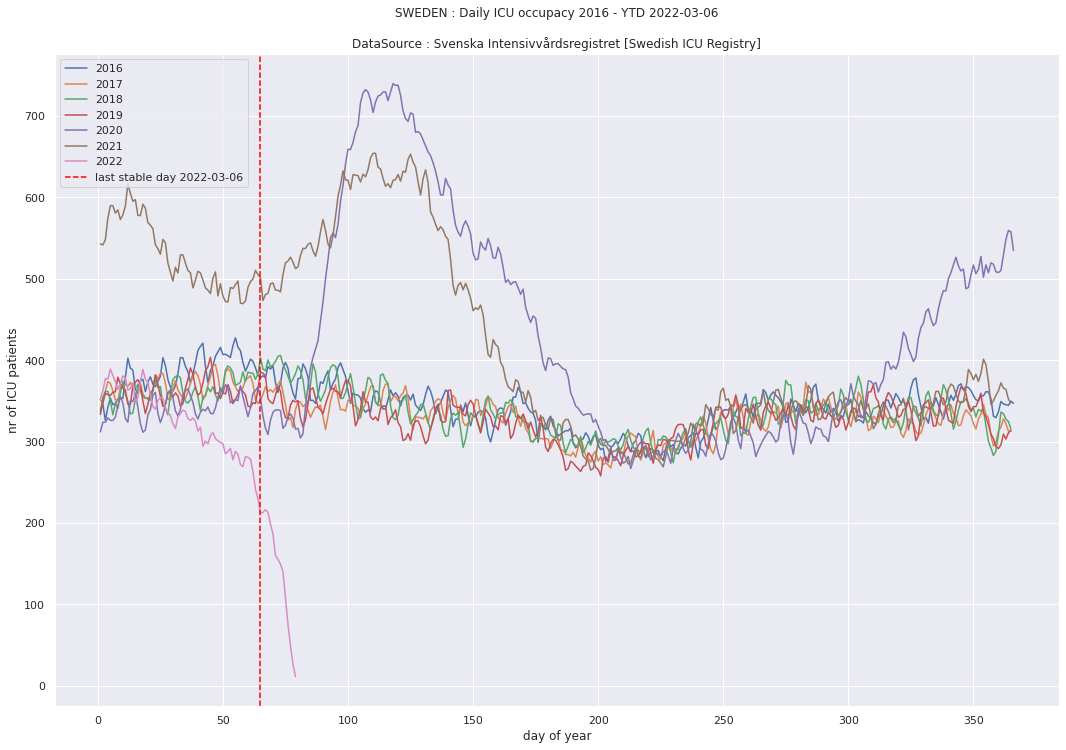

In [11]:
plt.figure(figsize=(18,12))

for y in years:
    plt.plot(all_data.loc[y].index.dayofyear,all_data.loc[y].values,label=y)
    
plt.xlabel('day of year')
plt.ylabel('nr of ICU patients')
plt.axvline(last_good_day_nr,label='last stable day {}'.format(last_good_day.date()),color='red',ls='dashed')
plt.legend(loc='upper left')
plt.title('SWEDEN : Daily ICU occupacy ' + years[0] +' - YTD {}\n\nDataSource : Svenska Intensivvårdsregistret [Swedish ICU Registry]'.format(
last_good_day.date()))


In [12]:
base_dates = all_data.loc[:'2019']
baseline = base_dates.groupby(base_dates.index.dayofyear).mean()
baseline

,occupacy
date,
1,340.403479
2,349.110890
3,352.243204
4,358.914448
5,358.049587
...,...
362,329.542717
363,324.561254
364,323.315880


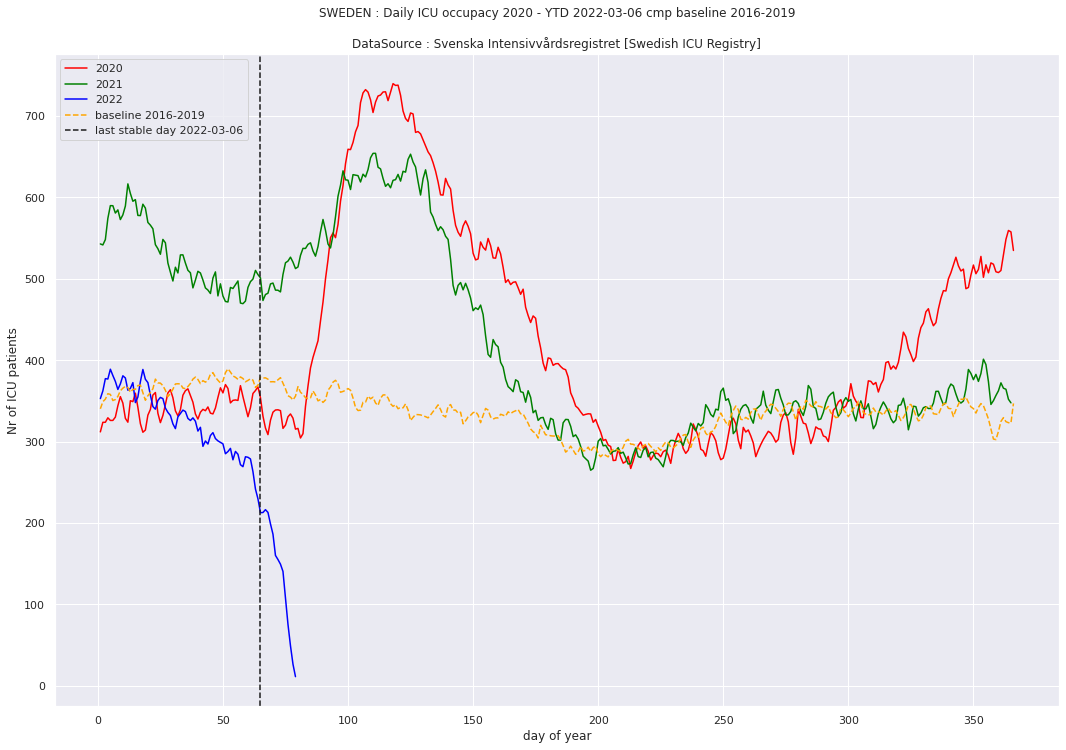

In [13]:
fig,ax = plt.subplots(figsize=(18,12))

ax.plot(all_data.loc['2020'].index.dayofyear,all_data.loc['2020'].values,label='2020',color='red')
ax.plot(all_data.loc['2021'].index.dayofyear,all_data.loc['2021'].values,label='2021',color='green')
ax.plot(all_data.loc['2022'].index.dayofyear,all_data.loc['2022'].values,label='2022',color='blue')

ax.plot(baseline.index,baseline.values,label='baseline 2016-2019',ls='dashed',color='orange')
ax.axvline(last_good_day_nr,label='last stable day {}'.format(last_good_day.date()),color='k',ls='dashed')
ax.legend(loc='upper left')
ax.set_xlabel('day of year')
ax.set_ylabel('Nr of ICU patients')
plt.title('SWEDEN : Daily ICU occupacy 2020 - YTD {} cmp baseline 2016-2019\n\nDataSource : Svenska Intensivvårdsregistret [Swedish ICU Registry]'.format(
last_good_day.date()))
plt.savefig('iva_occupacy_vs_baseline.jpg',format='jpg')


In [14]:
baseline

,occupacy
date,
1,340.403479
2,349.110890
3,352.243204
4,358.914448
5,358.049587
...,...
362,329.542717
363,324.561254
364,323.315880


,occupacy
date,
2022-02-09,313.038217
2022-02-10,317.630573
2022-02-11,294.258065
2022-02-12,300.845528
2022-02-13,297.113636
2022-02-14,307.553191
2022-02-15,311.086207
2022-02-16,303.820988
2022-02-17,300.987261


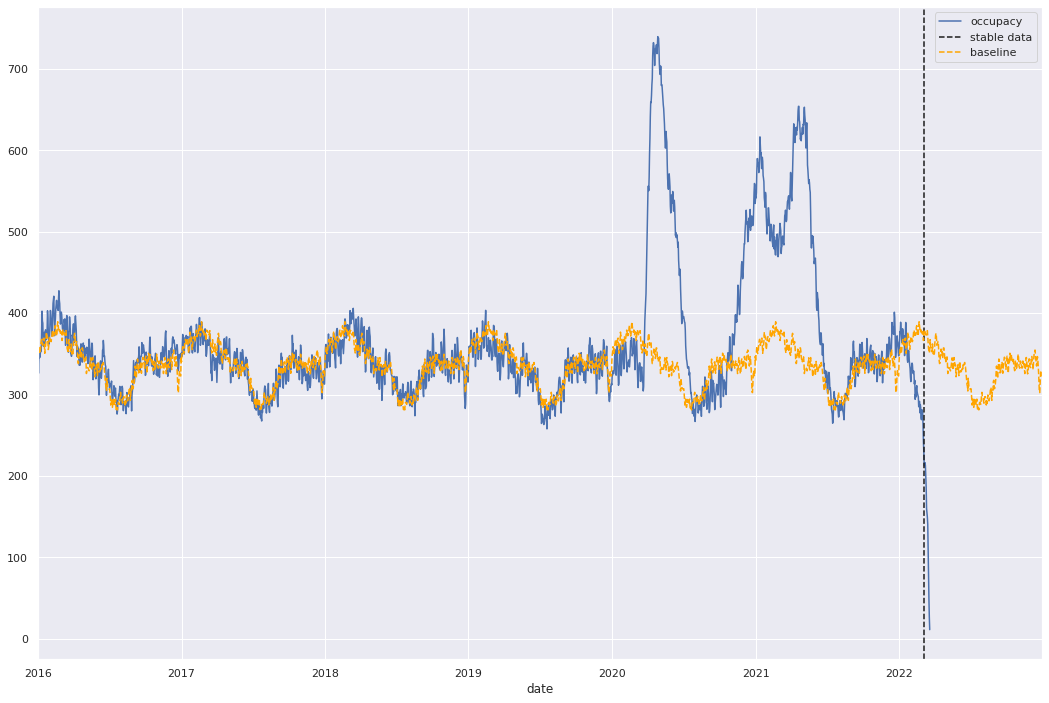

In [15]:

ax = all_data.plot(figsize=(18,12))
ax.axvline(last_good_day,label='last stable day {}'.format(last_good_day.date()),color='k',ls='dashed')

non_leap_base = baseline.iloc[:-1]
leap_base = baseline

full_period_base = pd.concat([leap_base,non_leap_base,non_leap_base,non_leap_base,leap_base,non_leap_base,
                             non_leap_base])
full_period_base.index = pd.date_range('2016-01-01',periods=len(full_period_base))
full_period_base.plot(ax=ax,ls='dashed',color='orange')
ax.legend(['occupacy','stable data','baseline'])
full_period_base.to_pickle('iva_daily_baseline.pkl')

all_data.tail(40)

In [16]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2271 entries, 2016-01-01 to 2022-03-20
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   occupacy  2271 non-null   float64
dtypes: float64(1)
memory usage: 100.0 KB


[16801 17167 17532 17897 18262 18628 18993 19357] [  0. 100. 200. 300. 400. 500. 600. 700. 800.]


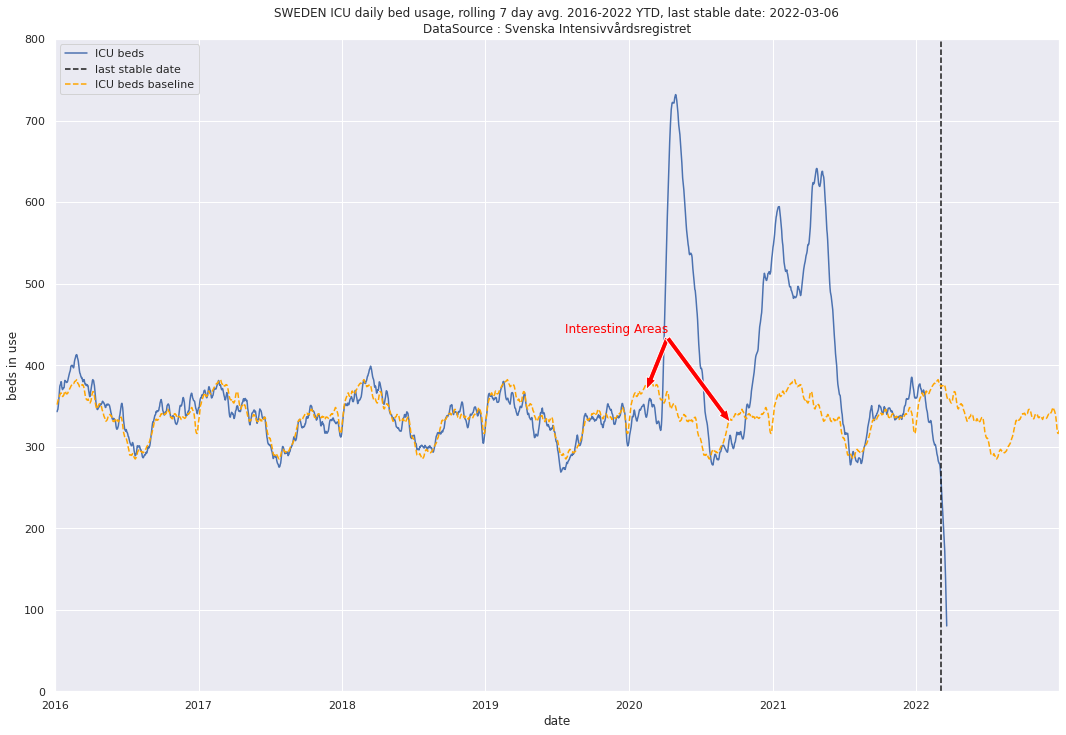

In [17]:
arrow_properties = dict(
    facecolor="red", width=5,
    headwidth=10, shrink=1)

label_x = 18100
label_y = 400
#arrow_x = 18300
arrow_x = '2020-02-15'
arrow_x2 = '2020-09-15'
arrow_y = 350



cred = '\nDataSource : Svenska Intensivvårdsregistret'
title = 'SWEDEN ICU daily bed usage, rolling 7 day avg. 2016-2022 YTD, last stable date: {}'.format(last_good_day.date()) + cred
ax = all_data.rolling(7).mean().plot(figsize=(18,12),title=title)
ax.axvline(last_good_day,label='last stable day {}'.format(last_good_day.date()),color='k',ls='dashed')
full_period_base.rolling(7).mean().plot(ax=ax,ls='dashed',color='orange')


x_data = ax.get_xticks(minor=False)
y_data = ax.get_yticks()



print (x_data,y_data)

#print (ax.transData.transform((200,200)))

ax.annotate('Interesting Areas',xy=(arrow_x,arrow_y+20),
           xytext = (label_x,label_y + 40),color='red',
           arrowprops = arrow_properties)


ax.annotate('                          ',xy=(arrow_x2 ,arrow_y-20),
           xytext = (label_x ,label_y+40),color='red',
           arrowprops = arrow_properties)


'''
ax.annotate('Interesting \nArea',xy=(arrow_x,arrow_y+20),
           xytext = (label_x,label_y + 40),color='red',
           arrowprops = arrow_properties)

ax.annotate('Interesting \nArea',xy=(arrow_x + 225,arrow_y-20),
           xytext = (label_x + 225,label_y),color='red',
           arrowprops = arrow_properties)
'''

ax.legend(['ICU beds','last stable date','ICU beds baseline'])
ax.set_ylabel('beds in use')
ax.set_ylim([0,800])
plt.savefig('iva_usage_rolling.jpg',format='jpg')

,occupacy
2019-10-01,-3.839174
2019-10-02,-6.594925
2019-10-03,-6.034647
2019-10-04,-6.727642
2019-10-05,-7.096123
...,...
2021-12-27,47.605056
2021-12-28,44.419729
2021-12-29,43.547315
2021-12-30,43.339490


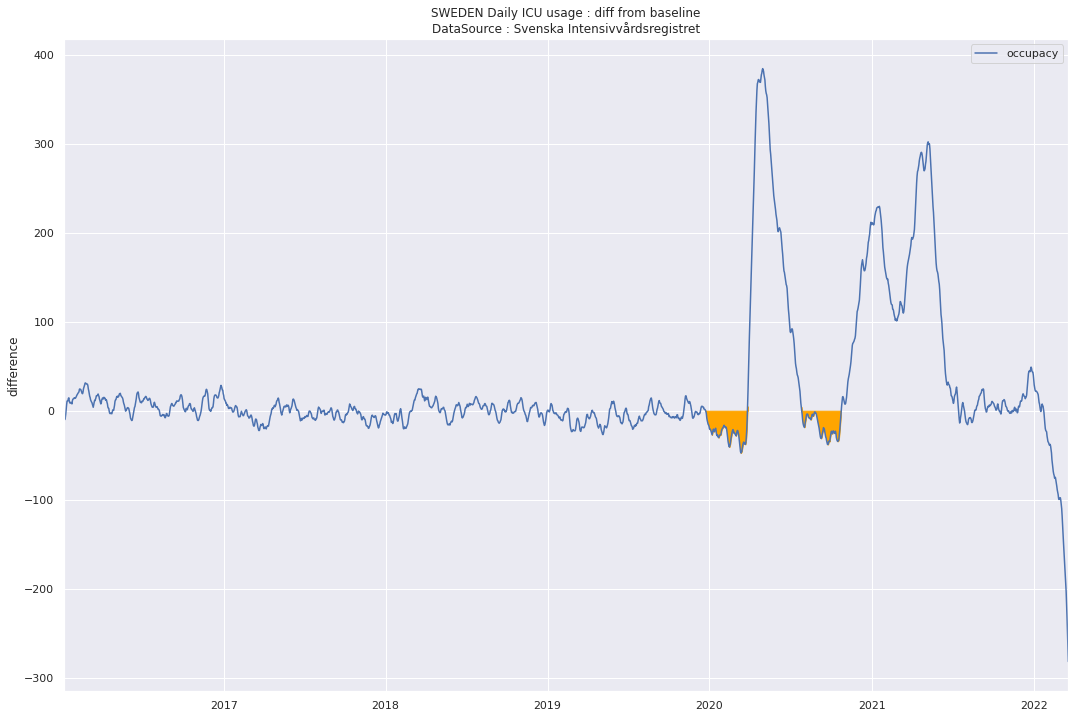

In [18]:
arrow_x = '2019-12-23'
arrow_x2 = '2020-03-27'
arrow_x3 = '2020-07-26'
arrow_x4 = '2020-10-23'

diff = (all_data.rolling(7).mean() - full_period_base.rolling(7).mean()).dropna()

title = 'SWEDEN Daily ICU usage : diff from baseline\nDataSource : Svenska Intensivvårdsregistret'
ax = diff.plot(figsize=(18,12),title=title)

ax.fill_between(x = diff.loc[arrow_x : arrow_x2].index,y1 = diff.loc[arrow_x : arrow_x2]['occupacy'],
               color='orange')
ax.fill_between(x = diff.loc[arrow_x3 : arrow_x4].index,y1 = diff.loc[arrow_x3 : arrow_x4]['occupacy'],
               color='orange')
ax.set_ylabel('difference')

plt.savefig('iva_diff_full.jpg',format='jpg')


diff = diff.loc['2019-10':'2021-12']
diff

2019-12-23     0.236807
2019-12-24    -0.814101
2019-12-25    -3.344956
2019-12-26    -8.164362
2019-12-27   -10.993025
                ...    
2020-03-23   -35.679035
2020-03-24   -30.514673
2020-03-25   -22.058455
2020-03-26   -10.388516
2020-03-27     4.984439
Freq: D, Name: occupacy, Length: 96, dtype: float64


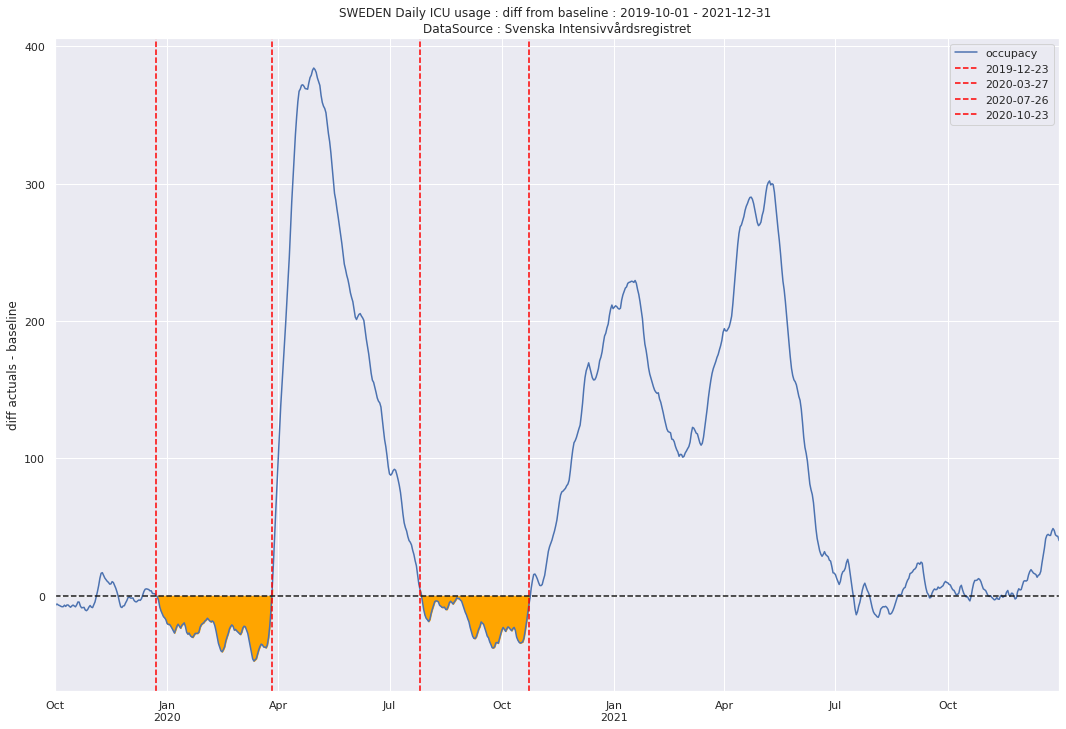

In [19]:



print (diff.loc[arrow_x : arrow_x2]['occupacy'])

title = 'SWEDEN Daily ICU usage : diff from baseline : {} - {} \nDataSource : Svenska Intensivvårdsregistret'.format(
diff.index[0].date(),diff.index[-1].date())

ax = diff.plot(figsize=(18,12),title=title)


ax.axvline(arrow_x,ls='dashed',color='red',label=arrow_x)
ax.axvline(arrow_x2,ls='dashed',color='red',label=arrow_x2)
ax.axvline(arrow_x3,ls='dashed',color='red',label=arrow_x3)
ax.axvline(arrow_x4,ls='dashed',color='red',label=arrow_x4)

ax.fill_between(x = diff.loc[arrow_x : arrow_x2].index,y1 = diff.loc[arrow_x : arrow_x2]['occupacy'],
               color='orange')
ax.fill_between(x = diff.loc[arrow_x3 : arrow_x4].index,y1 = diff.loc[arrow_x3 : arrow_x4]['occupacy'],
               color='orange')

ax.axhline(0,ls='dashed',color='k')

ax.set_ylabel('diff actuals - baseline')
ax.legend(loc='upper right')

plt.savefig('iva_daily_diff.jpg')


In [20]:
s = diff < 0
(~s).cumsum()[s].value_counts()



occupacy
29.0        94
152.0       89
0.0         35
422.0       23
17.0        20
490.0        8
416.0        7
476.0        5
497.0        3
448.0        2
489.0        2
491.0        2
495.0        1
dtype: int64

In [21]:
### FHM ###
fhm_url = 'https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data'
fhm_file = pd.ExcelFile(fhm_url)
fhm_file.sheet_names


['Antal per dag region',
 'Antal avlidna per dag',
 'Antal intensivvårdade per dag',
 'Totalt antal per region',
 'Totalt antal per kön',
 'Totalt antal per åldersgrupp',
 'Veckodata Region',
 'Veckodata Kommun_stadsdel',
 'Veckodata Riket',
 'FOHM 18 Mar 2022']

In [22]:
fhm_icu = fhm_file.parse(sheet_name=fhm_file.sheet_names[2],index_col=0,parse_dates=True)
fhm_icu.rename(columns={'Antal_intensivvårdade' : 'ICU_Daily_New_Covid_cases'},inplace=True)
fhm_icu.index.names=['date']

In [23]:
fhm_icu

,ICU_Daily_New_Covid_cases
date,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,0
2020-03-10,2
...,...
2022-03-13,4
2022-03-14,3
2022-03-15,1


In [24]:
sir_fhm = all_data.join(fhm_icu).dropna()
sir_fhm

,occupacy,ICU_Daily_New_Covid_cases
date,,
2020-03-06,331.376543,1.0
2020-03-07,316.763975,1.0
2020-03-08,308.671875,1.0
2020-03-09,326.267760,0.0
2020-03-10,336.220930,2.0
...,...,...
2022-03-13,155.211111,4.0
2022-03-14,149.513043,3.0
2022-03-15,140.649573,1.0


In [25]:
sir_fhm['ICU_Daily_non_Covid_beds_in_use'] = sir_fhm['occupacy'] - sir_fhm['ICU_Daily_New_Covid_cases']
sir_fhm

,occupacy,ICU_Daily_New_Covid_cases,ICU_Daily_non_Covid_beds_in_use
date,,,
2020-03-06,331.376543,1.0,330.376543
2020-03-07,316.763975,1.0,315.763975
2020-03-08,308.671875,1.0,307.671875
2020-03-09,326.267760,0.0,326.267760
2020-03-10,336.220930,2.0,334.220930
...,...,...,...
2022-03-13,155.211111,4.0,151.211111
2022-03-14,149.513043,3.0,146.513043
2022-03-15,140.649573,1.0,139.649573


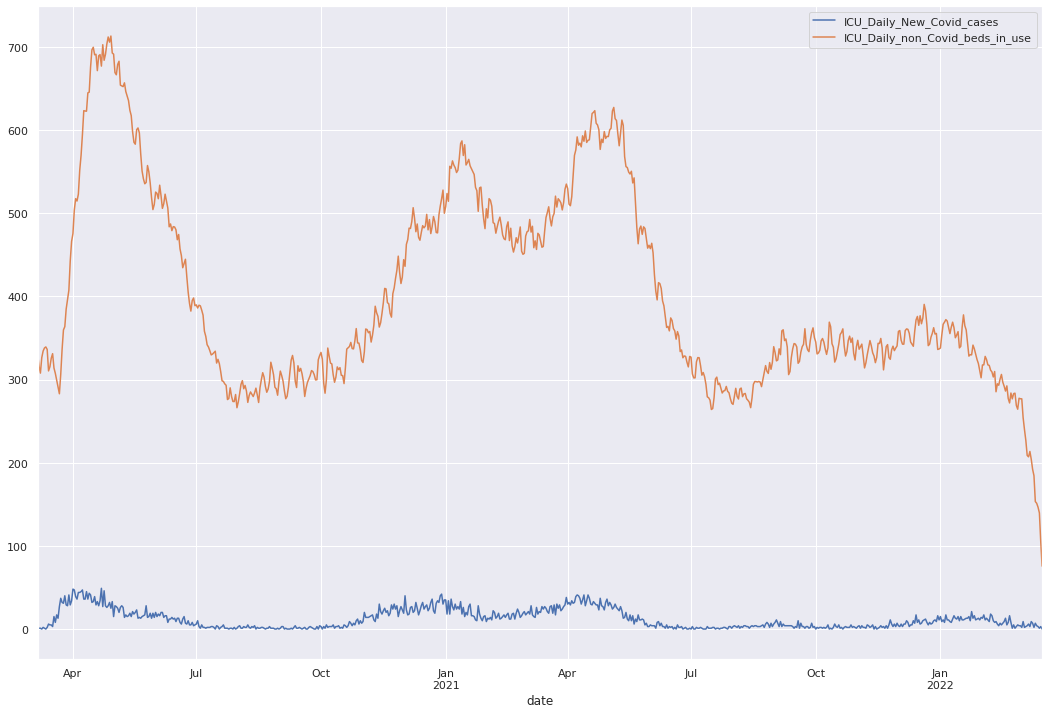

In [26]:
'''
Unable to draw any conclusions from the data since there's no info in the FHM data
on when a new case checks out
'''
ax = sir_fhm.plot(y=['ICU_Daily_New_Covid_cases','ICU_Daily_non_Covid_beds_in_use'],figsize=(18,12))


In [27]:
'''
https://portal.icuregswe.org/siri/en/report/corona.covid-dagligen
'''
sir_covid_url = 'iva_covid_occupancy.xlsx'
sir_covid_file = pd.ExcelFile(sir_covid_url)
sir_covid_file.sheet_names

['SIRI-portalen']

In [28]:
sir_covid = sir_covid_file.parse(sheet_name=sir_covid_file.sheet_names[0],skiprows=1,index_col=0,parse_dates=True)
sir_covid = sir_covid['Covid-19 Totalt']
sir_covid

Datum
2020-03-30    267
2020-03-31    298
2020-04-01    314
2020-04-02    347
2020-04-03    366
             ... 
2022-03-17     42
2022-03-18     32
2022-03-19     36
2022-03-20     33
2022-03-21     29
Name: Covid-19 Totalt, Length: 722, dtype: int64

In [29]:
sir_covid_non_covid = all_data.join(sir_covid).dropna()
sir_covid_non_covid

,occupacy,Covid-19 Totalt
date,,
2020-03-30,471.410448,267.0
2020-03-31,499.944444,298.0
2020-04-01,523.381818,314.0
2020-04-02,550.548571,347.0
2020-04-03,556.372549,366.0
...,...,...
2022-03-16,107.910112,43.0
2022-03-17,75.632353,42.0
2022-03-18,49.278689,32.0


In [30]:
sir_covid_non_covid['Non-Covid'] = sir_covid_non_covid['occupacy'] - sir_covid_non_covid['Covid-19 Totalt']
sir_covid_non_covid

,occupacy,Covid-19 Totalt,Non-Covid
date,,,
2020-03-30,471.410448,267.0,204.410448
2020-03-31,499.944444,298.0,201.944444
2020-04-01,523.381818,314.0,209.381818
2020-04-02,550.548571,347.0,203.548571
2020-04-03,556.372549,366.0,190.372549
...,...,...,...
2022-03-16,107.910112,43.0,64.910112
2022-03-17,75.632353,42.0,33.632353
2022-03-18,49.278689,32.0,17.278689


In [31]:
sir_covid_non_covid.rename(columns={'Covid-19 Totalt' : 'Covid','occupacy' : 'Total'},inplace=True)

In [32]:
sir_covid_non_covid

,Total,Covid,Non-Covid
date,,,
2020-03-30,471.410448,267.0,204.410448
2020-03-31,499.944444,298.0,201.944444
2020-04-01,523.381818,314.0,209.381818
2020-04-02,550.548571,347.0,203.548571
2020-04-03,556.372549,366.0,190.372549
...,...,...,...
2022-03-16,107.910112,43.0,64.910112
2022-03-17,75.632353,42.0,33.632353
2022-03-18,49.278689,32.0,17.278689


In [33]:
# daily average per week 
sir_covid_non_covid = sir_covid_non_covid.resample('W').mean()

In [34]:
sir_covid_non_covid.index

DatetimeIndex(['2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07',
               ...
               '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-06',
               '2022-02-13', '2022-02-20', '2022-02-27', '2022-03-06',
               '2022-03-13', '2022-03-20'],
              dtype='datetime64[ns]', name='date', length=103, freq='W-SUN')

In [35]:
covid_period_all_icu_base = full_period_base.resample('W').mean()
covid_period_all_icu_base = covid_period_all_icu_base.loc[sir_covid_non_covid.index[0]:]
covid_period_all_icu_base

,occupacy
2020-04-05,364.245592
2020-04-12,358.502472
2020-04-19,348.156521
2020-04-26,351.505995
2020-05-03,342.631446
...,...
2022-12-04,339.486062
2022-12-11,342.295911
2022-12-18,345.118284
2022-12-25,325.211593


In [36]:
print (covid_period_all_icu_base.info())
print()
sir_covid_non_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2020-04-05 to 2023-01-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   occupacy  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2020-04-05 to 2022-03-20
Freq: W-SUN
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Total      103 non-null    float64
 1   Covid      103 non-null    float64
 2   Non-Covid  103 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB


In [37]:
sir_covid_non_covid.index = pd.to_datetime(sir_covid_non_covid.index)
sir_covid_non_covid.index

DatetimeIndex(['2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07',
               ...
               '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-06',
               '2022-02-13', '2022-02-20', '2022-02-27', '2022-03-06',
               '2022-03-13', '2022-03-20'],
              dtype='datetime64[ns]', name='date', length=103, freq='W-SUN')

In [38]:
covid_period_all_icu_base.index

DatetimeIndex(['2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07',
               ...
               '2022-10-30', '2022-11-06', '2022-11-13', '2022-11-20',
               '2022-11-27', '2022-12-04', '2022-12-11', '2022-12-18',
               '2022-12-25', '2023-01-01'],
              dtype='datetime64[ns]', length=144, freq='W-SUN')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]


Text(0.5, 0, 'week of')

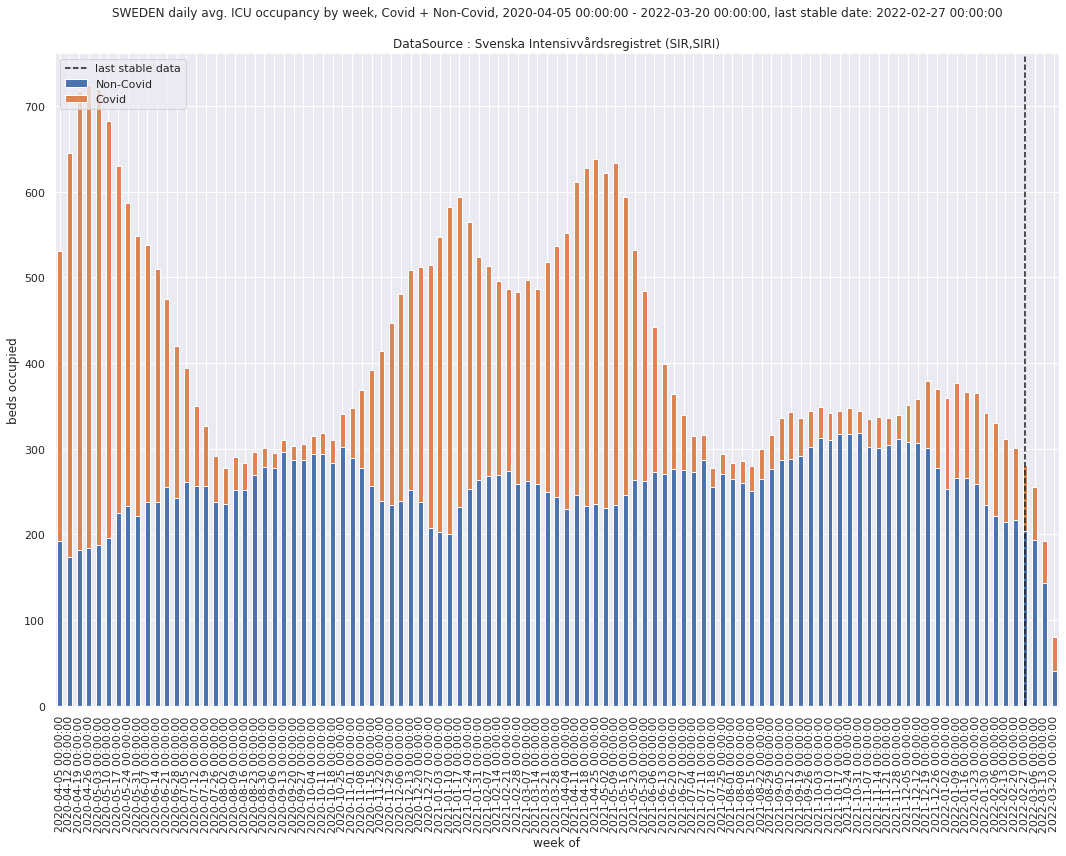

In [39]:
fig,ax = plt.subplots(figsize=(18,12))
sir_covid_non_covid.index = sir_covid_non_covid.index
sir_covid_non_covid.plot(ax=ax,kind='bar',stacked=True,y=['Non-Covid','Covid'])


print (ax.get_xticks())
ax.axvline(ax.get_xticks()[-4],color='k',ls='dashed',label='last stable data')
ax.legend(loc='upper left')
ax.set_title('SWEDEN daily avg. ICU occupancy by week, Covid + Non-Covid, {} - {}, last stable date: {}\n\nDataSource : Svenska Intensivvårdsregistret (SIR,SIRI)'.format(
sir_covid_non_covid.index[0],sir_covid_non_covid.index[-1],sir_covid_non_covid.index[-4]))
ax.set_ylabel('beds occupied')
ax.set_xlabel('week of')


In [40]:
combined_sir_and_base = sir_covid_non_covid.join(covid_period_all_icu_base)
combined_sir_and_base.rename(columns={'occupacy' : 'baseline'},inplace=True)
combined_sir_and_base

,Total,Covid,Non-Covid,baseline
date,,,,
2020-04-05,531.290134,339.142857,192.147277,364.245592
2020-04-12,645.351602,471.285714,174.065888,358.502472
2020-04-19,717.035978,534.714286,182.321692,348.156521
2020-04-26,724.963842,540.428571,184.535271,351.505995
2020-05-03,719.598556,532.285714,187.312842,342.631446
...,...,...,...,...
2022-02-20,300.727207,83.571429,217.155778,379.083137
2022-02-27,281.555320,77.428571,204.126748,381.223360
2022-03-06,255.505241,62.000000,193.505241,373.821001


In [41]:
combined_sir_and_base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2020-04-05 to 2022-03-20
Freq: W-SUN
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Total      103 non-null    float64
 1   Covid      103 non-null    float64
 2   Non-Covid  103 non-null    float64
 3   baseline   103 non-null    float64
dtypes: float64(4)
memory usage: 8.1 KB


In [42]:
'''
pandas bug: can't plot using datetime index a line and bar on same plot 
https://stackoverflow.com/questions/42455391/python-different-behaviour-of-datetimeindex-while-plotting-line-and-bar-plots
'''
combined_sir_and_base.index = combined_sir_and_base.index.astype(str)

In [43]:
combined_sir_and_base.clip(lower=0)

,Total,Covid,Non-Covid,baseline
date,,,,
2020-04-05,531.290134,339.142857,192.147277,364.245592
2020-04-12,645.351602,471.285714,174.065888,358.502472
2020-04-19,717.035978,534.714286,182.321692,348.156521
2020-04-26,724.963842,540.428571,184.535271,351.505995
2020-05-03,719.598556,532.285714,187.312842,342.631446
...,...,...,...,...
2022-02-20,300.727207,83.571429,217.155778,379.083137
2022-02-27,281.555320,77.428571,204.126748,381.223360
2022-03-06,255.505241,62.000000,193.505241,373.821001


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]


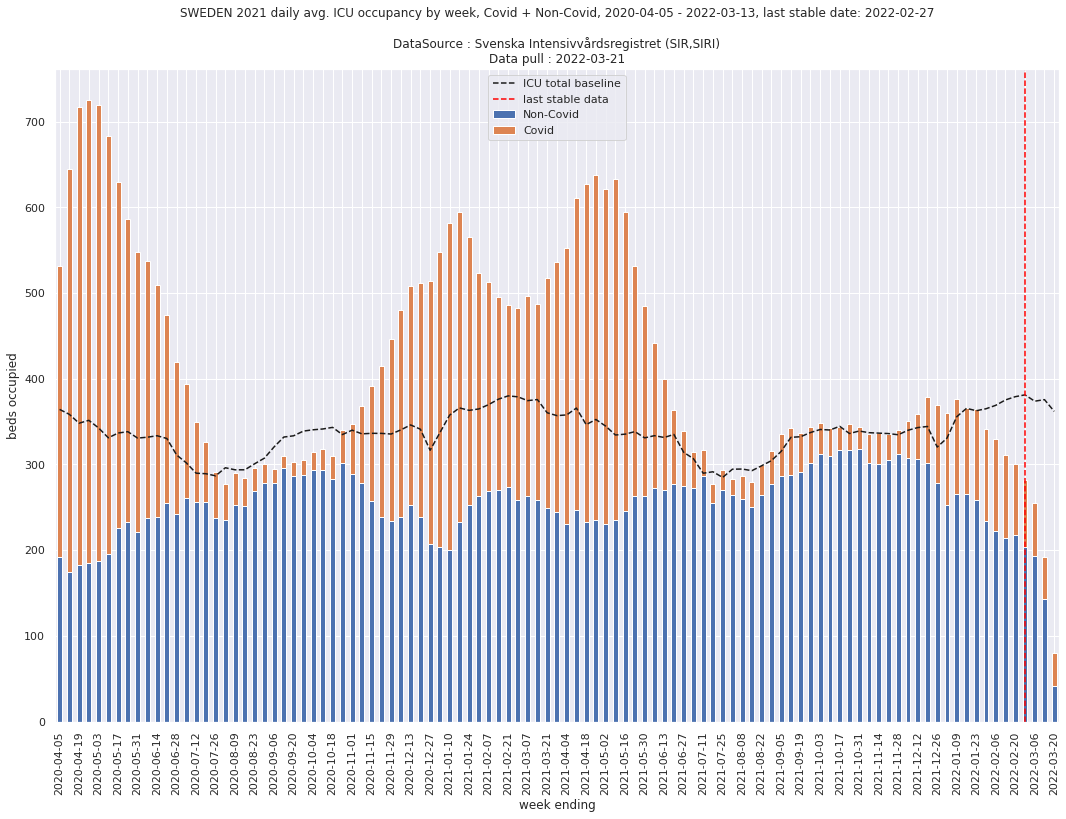

In [44]:
### reporting on covid specific beds is updated faster than the all cause beds. therefore ###
### the latest weeks can get negative ###

fig,ax = plt.subplots(figsize=(18,12))
combined_sir_and_base.clip(lower=0).plot(kind='bar',stacked=True,y=['Non-Covid','Covid'],ax=ax)
ax.plot(combined_sir_and_base.index,combined_sir_and_base['baseline'],ls='dashed',color='k',label='ICU total baseline')

ax.set_title('SWEDEN 2021 daily avg. ICU occupancy by week, Covid + Non-Covid, {} - {}, last stable date: {}\n\nDataSource : Svenska Intensivvårdsregistret (SIR,SIRI)\nData pull : {}'.format(sir_covid_non_covid.index[0].date(),sir_covid_non_covid.index[-2].date(),sir_covid_non_covid.index[-4].date(),
pd.to_datetime('today').date()))

print (ax.get_xticks())

ax.axvline(ax.get_xticks()[-4],color='red',ls='dashed',label='last stable data')


#ax.legend(['Non-Covid','Covid','ICU-baseline','last stable date'][::-1])
ax.legend(loc='upper center')
ax.set_ylabel('beds occupied')
ax.set_xlabel('week ending')


for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
   


plt.savefig('iva_covid_non_covid.jpg')

In [45]:
from datetime import date

variants = pd.read_pickle('variants.pkl')
variants.index = pd.DatetimeIndex(pd.to_datetime(variants.index.str.strip() + '-01',format='%Y-%W-%w%f').date)
variants.index

DatetimeIndex(['2021-02-07', '2021-02-14', '2021-02-21', '2021-02-28',
               '2021-03-07', '2021-03-14', '2021-03-21', '2021-03-28',
               '2021-04-04', '2021-04-11', '2021-04-18', '2021-04-25',
               '2021-05-02', '2021-05-09', '2021-05-16', '2021-05-23',
               '2021-05-30', '2021-06-06', '2021-06-13', '2021-06-20',
               '2021-06-27', '2021-07-04', '2021-07-11', '2021-07-18',
               '2021-07-25', '2021-08-01', '2021-08-08', '2021-08-15',
               '2021-08-22', '2021-08-29', '2021-09-05', '2021-09-12',
               '2021-09-19', '2021-09-26', '2021-10-03', '2021-10-10',
               '2021-10-17', '2021-10-24', '2021-10-31', '2021-11-07',
               '2021-11-14', '2021-11-21', '2021-11-28', '2021-12-05',
               '2021-12-12', '2021-12-19', '2021-12-26', '2022-01-02',
               '2022-01-09', '2022-01-16', '2022-01-23', '2022-01-30',
               '2022-02-06', '2022-02-13', '2022-02-20', '2022-02-27',
      

In [46]:
combined_sir_and_base.index = pd.DatetimeIndex(combined_sir_and_base.index)

combined_sir_base_variants = (combined_sir_and_base.join(variants))
combined_sir_base_variants.drop('year',axis=1,inplace=True)
combined_sir_base_variants.dropna(inplace=True)
combined_sir_base_variants

,Total,Covid,Non-Covid,baseline,alpha,beta,gamma,delta,omicron
date,,,,,,,,,
2021-02-07,513.193832,244.571429,268.622403,369.861705,1120.0,90.0,6.0,0.0,0.0
2021-02-14,495.787475,226.142857,269.644617,376.170599,2338.0,175.0,5.0,0.0,0.0
2021-02-21,486.434380,213.000000,273.434380,380.034744,3317.0,223.0,10.0,0.0,0.0
2021-02-28,482.898111,224.428571,258.469539,378.933388,4457.0,216.0,10.0,0.0,0.0
2021-03-07,496.554103,233.714286,262.839817,374.481642,4715.0,157.0,6.0,0.0,0.0
2021-03-14,486.825005,227.857143,258.967862,375.753888,6159.0,248.0,6.0,0.0,0.0
2021-03-21,517.319302,267.571429,249.747874,360.359742,5631.0,287.0,9.0,0.0,0.0
2021-03-28,536.029535,292.000000,244.029535,356.987129,6722.0,333.0,15.0,0.0,0.0
2021-04-04,552.036043,322.000000,230.036043,357.830003,3691.0,270.0,6.0,19.0,0.0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]


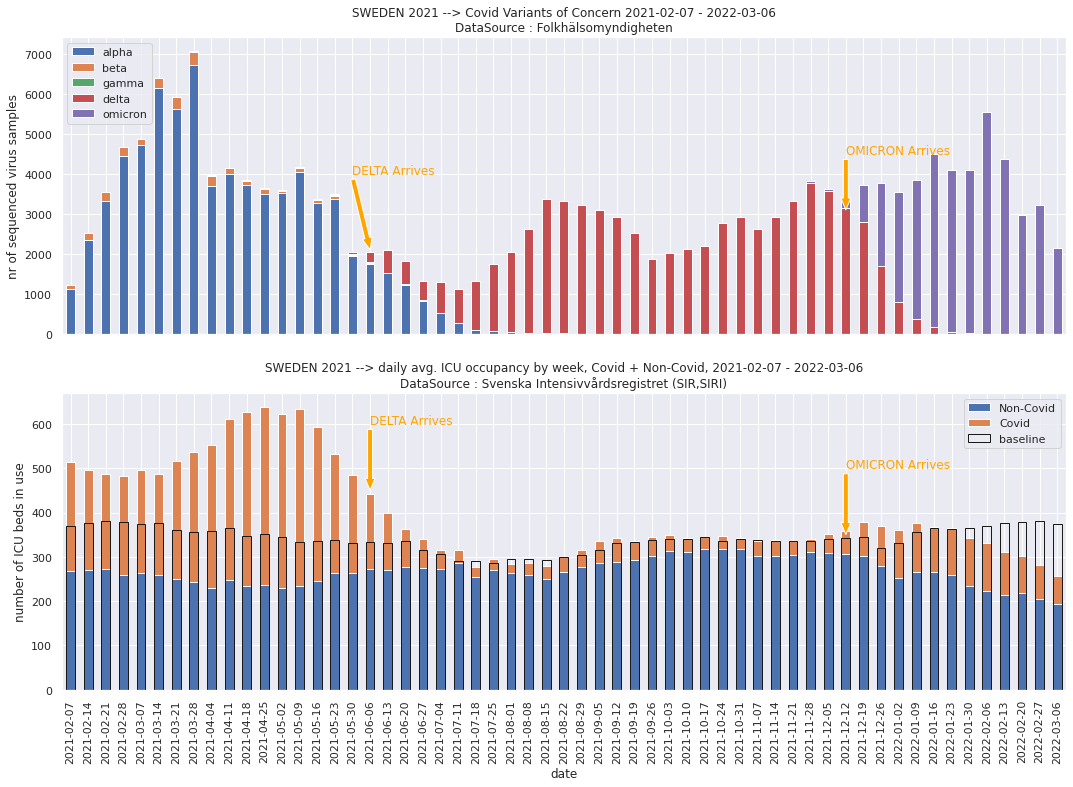

In [47]:
arrow_properties = dict(
    facecolor="orange", width=5,
    headwidth=10, shrink=1)


fig,axes = plt.subplots(2,figsize=(18,12),sharex=True)

xticks = combined_sir_base_variants.index.date

combined_sir_base_variants.plot(y=['Non-Covid','Covid'],kind='bar',stacked=True,ax=axes[1])
combined_sir_base_variants.plot(y='baseline',ax=axes[1],kind='bar',facecolor='none',edgecolor='k')
combined_sir_base_variants.plot(y=['alpha','beta','gamma','delta','omicron'],kind='bar',stacked=True,ax=axes[0])

axes[1].set_title('SWEDEN 2021 --> daily avg. ICU occupancy by week, Covid + Non-Covid, {} - {}\nDataSource : Svenska Intensivvårdsregistret (SIR,SIRI)'.format(
    combined_sir_base_variants.index[0].date(),combined_sir_base_variants.index[-1].date()))

axes[1].set_ylabel('number of ICU beds in use')

_= axes[1].set_xticklabels(xticks)

_= axes[0].set_title('SWEDEN 2021 --> Covid Variants of Concern {} - {}\nDataSource : Folkhälsomyndigheten'.format(
combined_sir_base_variants.index[0].date(),combined_sir_base_variants.index[-1].date()))

axes[0].set_ylabel('nr of sequenced virus samples')
print (axes[0].get_xticks())


axes[0].annotate('DELTA Arrives',xy=(17,2100),
           xytext = (16,4000),color='orange',
           arrowprops = arrow_properties)

axes[1].annotate('DELTA Arrives',xy=(17,450),
           xytext = (17,600),color='orange',
           arrowprops = arrow_properties)

axes[0].annotate('OMICRON Arrives',xy=(44,3100),
           xytext = (44,4500),color='orange',
           arrowprops = arrow_properties)

axes[1].annotate('OMICRON Arrives',xy=(44,350),
           xytext = (44,500),color='orange',
           arrowprops = arrow_properties)


plt.savefig('scb_excess_icus_and_variants.jpg',format='jpg')